### Set up water network model

In this example, we test our quantum solvers into a slightly larger network as contained in `Net1Loops.inp`. Let's start by setting up the model:

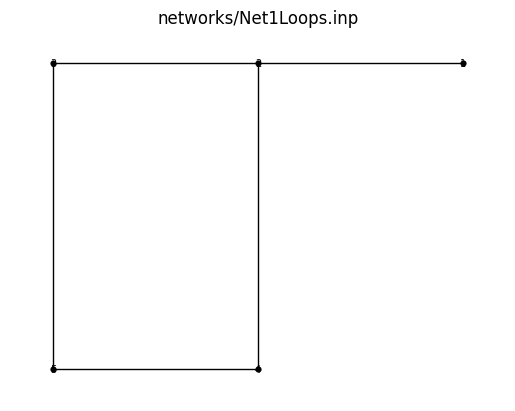

<Axes: title={'center': 'networks/Net1Loops.inp'}>

In [3]:
import os
import wntr
import wntr_quantum

os.environ["EPANET_TMP"] = "/home/nico/.epanet_quantum"
os.environ["EPANET_QUANTUM"] = "/home/nico/QuantumApplicationLab/vitens/EPANET"

# set up network model
inp_file = "networks/Net1Loops.inp"
wn = wntr.network.WaterNetworkModel(inp_file)

# plot network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)

# print options
# dict(wn.options.hydraulic)

### Solve model using the classical Epanet simulator

We now solve the same problem using the classical Epanet simulator. Note that, by default, `QuantumEpanetSimulator` uses a classical `CholeskySolver` to iteratively solve the linear problem.

In [4]:
import sys

# define the classical EPANET simulator
sim = wntr_quantum.sim.QuantumEpanetSimulator(wn)

# run the EPANET simulation
results_epanet = sim.run_sim()

# remember to set up EPANET Quantum environment variables!
epanet_path = os.environ["EPANET_QUANTUM"]
epanet_tmp = os.environ["EPANET_TMP"]

# check paths
print(f"Your EPANET quantum path: {epanet_path}")
print(f"Your EPANET temp dir: {epanet_tmp}\n")

util_path = os.path.join(epanet_path, "src/py/")
sys.path.append(util_path)

from quantum_linsolve import load_json_data

epanet_A, epanet_b = load_json_data(os.path.join(epanet_tmp, "smat.json"))

# set the size of the Jacobian (A matrix)
epanet_A_dim = epanet_A.todense().shape[0]
print(f"Size of the Jacobian in EPANET simulator: {epanet_A_dim}")
print(f"Size of the b vector in EPANET simulator: {epanet_b.shape[0]}")

# save number of nodes and pipes
n_nodes = (len(results_epanet.node["pressure"].iloc[0]),)
n_pipes = len(results_epanet.link["flowrate"].iloc[0])

results_epanet.node["pressure"], results_epanet.link["flowrate"]

/home/nico/QuantumApplicationLab/vitens/wntr-quantum/wntr_quantum/epanet/Linux/libepanet22_amd64.so
Your EPANET quantum path: /home/nico/QuantumApplicationLab/vitens/EPANET
Your EPANET temp dir: /home/nico/.epanet_quantum

Size of the Jacobian in EPANET simulator: 4
Size of the b vector in EPANET simulator: 4


(name          2          3          4          5             1
 0     57.939995  31.496479  52.434612  21.174667  4.394531e-07,
 name         1         2         3         4         5
 0     0.163867  0.059455  0.076645  0.043315  0.031685)

### Solve linear system with VQLS and the final matrices from EPANET

For testing purposes, we start by solving the linear system with VQLS and the final A and b matrices from the classical EPANET simulator. Here, we are **preconditioning** the initial linear system using diagonal scaling and also using a **mix of two classical optimizers**.

In [5]:
import numpy as np

from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_algorithms import optimizers as opt

from quantum_newton_raphson.vqls_solver import VQLS_SOLVER

n_qubits = int(np.ceil(np.log2(epanet_A_dim)))

qc = RealAmplitudes(n_qubits, reps=3, entanglement="full")
estimator = Estimator()

linear_solver = VQLS_SOLVER(
    estimator=estimator,
    ansatz=qc,
    optimizer=[opt.COBYLA(maxiter=1000, disp=True), opt.CG(maxiter=500, disp=True)],
    matrix_decomposition="symmetric",
    verbose=True,
    preconditioner="diagonal_scaling",
)

res = linear_solver(epanet_A, epanet_b)

VQLS Iteration 136 Cost 5.066e-08
   Normal return from subroutine COBYLA

   NFVALS =  136   F = 5.066030E-08    MAXCV = 0.000000E+00
   X =-1.347440E-02  -8.807702E-01   1.307708E+00   2.989201E+00   3.526457E+00
      -2.800616E-01   2.854411E+00   1.854796E+00
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 63
         Gradient evaluations: 7


Let's check the evolution of the cost function

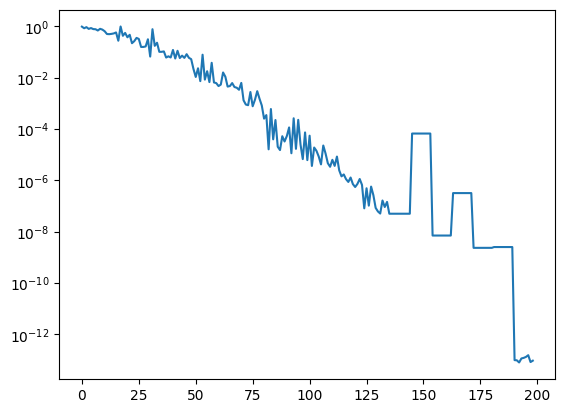

In [6]:
import matplotlib.pyplot as plt

plt.semilogy(res.logger.values)

and visualize graphically the solution

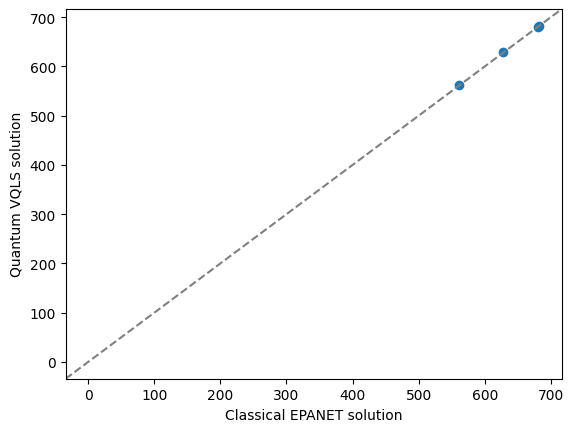

(array([561.597, 628.269, 682.218, 680.56 ]),
 array([561.596, 628.269, 682.218, 680.56 ]))

In [7]:
import numpy as np

ref = np.linalg.solve(epanet_A.todense(), epanet_b)

plt.scatter(ref, res.solution)
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.xlabel("Classical EPANET solution")
plt.ylabel("Quantum VQLS solution")
plt.show()

ref, res.solution